In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers # requires transformers==4.35.2
device = torch.device('cuda:0')

/home/vijay/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
print(transformers.__version__)

4.35.2


In [3]:
draft_model_name = "deepseek-ai/deepseek-coder-1.3b-base"
draft_model = AutoModelForCausalLM.from_pretrained(draft_model_name, trust_remote_code=True, device_map="cuda:0", torch_dtype=torch.float16, use_flash_attention_2=True)
print(draft_model.device)

/home/vijay/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/vijay/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/vijay/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


cuda:0


/home/vijay/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
model_name = "deepseek-ai/deepseek-coder-6.7b-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, device_map="cuda:1", torch_dtype=torch.float16, use_flash_attention_2=True) # , use_flash_attention=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
model.device

device(type='cuda', index=1)

In [6]:
import copy
import inspect
import warnings
from dataclasses import dataclass
from typing import TYPE_CHECKING, Any, Callable, Dict, List, Optional, Tuple, Union

import torch
import torch.distributed as dist
from torch import nn

from transformers.integrations.deepspeed import is_deepspeed_zero3_enabled
from transformers.modeling_outputs import CausalLMOutputWithPast, Seq2SeqLMOutput
from transformers.models.auto import (
    MODEL_FOR_CAUSAL_IMAGE_MODELING_MAPPING,
    MODEL_FOR_CAUSAL_LM_MAPPING,
    MODEL_FOR_SEQ_TO_SEQ_CAUSAL_LM_MAPPING,
    MODEL_FOR_SPEECH_SEQ_2_SEQ_MAPPING,
    MODEL_FOR_VISION_2_SEQ_MAPPING,
)
from transformers.utils import ExplicitEnum, ModelOutput, is_accelerate_available, logging
from transformers.generation.beam_constraints import DisjunctiveConstraint, PhrasalConstraint
from transformers.generation.beam_search import BeamScorer, BeamSearchScorer, ConstrainedBeamSearchScorer
from transformers.generation.configuration_utils import GenerationConfig
from transformers.generation.logits_process import (
    EncoderNoRepeatNGramLogitsProcessor,
    EncoderRepetitionPenaltyLogitsProcessor,
    EpsilonLogitsWarper,
    EtaLogitsWarper,
    ExponentialDecayLengthPenalty,
    ForcedBOSTokenLogitsProcessor,
    ForcedEOSTokenLogitsProcessor,
    ForceTokensLogitsProcessor,
    HammingDiversityLogitsProcessor,
    InfNanRemoveLogitsProcessor,
    LogitNormalization,
    LogitsProcessorList,
    MinLengthLogitsProcessor,
    MinNewTokensLengthLogitsProcessor,
    NoBadWordsLogitsProcessor,
    NoRepeatNGramLogitsProcessor,
    PrefixConstrainedLogitsProcessor,
    RepetitionPenaltyLogitsProcessor,
    SequenceBiasLogitsProcessor,
    SuppressTokensAtBeginLogitsProcessor,
    SuppressTokensLogitsProcessor,
    TemperatureLogitsWarper,
    TopKLogitsWarper,
    TopPLogitsWarper,
    TypicalLogitsWarper,
    UnbatchedClassifierFreeGuidanceLogitsProcessor,
)
from transformers.generation.stopping_criteria import (
    MaxLengthCriteria,
    MaxTimeCriteria,
    StoppingCriteria,
    StoppingCriteriaList,
    validate_stopping_criteria,
)

from transformers.generation.utils import _crop_past_key_values
import difflib

@dataclass
class GreedySearchDecoderOnlyOutput(ModelOutput):
    """
    Base class for outputs of decoder-only generation models using greedy search.


    Args:
        sequences (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            The generated sequences. The second dimension (sequence_length) is either equal to `max_length` or shorter
            if all batches finished early due to the `eos_token_id`.
        scores (`tuple(torch.FloatTensor)` *optional*, returned when `output_scores=True` is passed or when `config.output_scores=True`):
            Processed prediction scores of the language modeling head (scores for each vocabulary token before SoftMax)
            at each generation step. Tuple of `torch.FloatTensor` with up to `max_new_tokens` elements (one element for
            each generated token), with each tensor of shape `(batch_size, config.vocab_size)`.
        attentions (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `output_attentions=True` is passed or `config.output_attentions=True`):
            Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of
            `torch.FloatTensor` of shape `(batch_size, num_heads, generated_length, sequence_length)`.
        hidden_states (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of
            `torch.FloatTensor` of shape `(batch_size, generated_length, hidden_size)`.
    """

    sequences: torch.LongTensor = None
    scores: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[Tuple[torch.FloatTensor]]] = None
    hidden_states: Optional[Tuple[Tuple[torch.FloatTensor]]] = None




In [7]:

@torch.no_grad()
def find_candidate_pred_tokens(input_ids, max_ngram_size=3, num_pred_tokens=10):
    input_length = input_ids.size(1)

    # Ensure max_ngram_size and num_pred_tokens are valid
    if max_ngram_size <= 0 or num_pred_tokens <= 0 or max_ngram_size > input_length:
        raise ValueError("Invalid max_ngram_size or num_pred_tokens")

    for ngram_size in range(max_ngram_size, 0, -1):
        # Extract the last n tokens as our search ngram
        ngram = input_ids[0, -ngram_size:].tolist()

        # Create sliding windows of size ngram_size
        windows = input_ids.unfold(dimension=1, size=ngram_size, step=1)

        # Convert ngram to a tensor for comparison
        ngram_tensor = torch.tensor(ngram, device=input_ids.device).unsqueeze(0)

        # Find where the windows match the ngram
        matches = (windows == ngram_tensor).all(dim=2)

        # Get the indices of matches
        match_indices = matches.nonzero(as_tuple=True)[1]

        # Iterate through match indices to find a valid continuation
        for idx in match_indices:
            start_idx = idx + ngram_size
            end_idx = start_idx + num_pred_tokens
            # Ensure we don't go beyond the length of input_ids and avoid self-match
            # if end_idx <= input_length and start_idx < input_length - ngram_size:
            #     return input_ids[0, start_idx:end_idx]
            if start_idx < input_length - ngram_size:
                return input_ids[0, start_idx:min(end_idx, input_length)]

    # If no match is found, return an empty tensor
    return torch.tensor([], dtype=torch.long, device=input_ids.device)

In [8]:
COLORS = ["\x1b[31m", "\x1b[32m", "\x1b[34m", "\x1b[35m"]  # Red, Green, Blue, Magenta
UNDERLINE = "\x1b[4m"
RESET = "\x1b[0m"

In [9]:
@torch.no_grad()
def greedy_search_pld(
        self,
        input_ids: torch.LongTensor,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[Union[int, List[int]]] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_scores: Optional[bool] = None,
        return_dict_in_generate: Optional[bool] = None,
        synced_gpus: bool = False,
        streamer: Optional["BaseStreamer"] = None,
        draft_matching_window_size = 3,
        draft_num_candidate_tokens = 10,
        print_output=True,
        **model_kwargs,
    ):

        global tokenizer

        # init values
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()
        pad_token_id = pad_token_id if pad_token_id is not None else self.generation_config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.generation_config.eos_token_id
        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None

        # # init attention / hidden states / scores tuples
        scores = () if (return_dict_in_generate and output_scores) else None

        max_len = stopping_criteria[0].max_length

        i = 0
        current_color_index = 0

        while True:
            i += 1
            cur_len = input_ids.shape[-1]

            candidate_pred_tokens = find_candidate_pred_tokens(input_ids, draft_matching_window_size, draft_num_candidate_tokens)

            if len(candidate_pred_tokens) == 0:
                candidate_pred_tokens = torch.tensor([100], device=input_ids.device).unsqueeze(0)
            else:
                candidate_pred_tokens = candidate_pred_tokens.unsqueeze(0)
            
            candidate_input_ids = torch.cat((input_ids, candidate_pred_tokens), dim=1)
            
            candidate_length = candidate_input_ids.shape[1] - input_ids.shape[1]

            candidate_kwargs = copy.copy(model_kwargs)
            candidate_kwargs = self._extend_attention_mask(candidate_kwargs, candidate_input_ids.shape[1])
            candidate_kwargs = self._extend_token_type_ids(candidate_kwargs, candidate_input_ids.shape[1])

            model_inputs = self.prepare_inputs_for_generation(candidate_input_ids, **candidate_kwargs)
            
            # prepare model inputs
            # model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )


            new_logits = outputs.logits[:, -candidate_length - 1 :]  # excludes the input prompt if present
            selected_tokens = new_logits.argmax(dim=-1)
            candidate_new_tokens = candidate_input_ids[:, -candidate_length:]
            n_matches = ((~(candidate_new_tokens == selected_tokens[:, :-1])).cumsum(dim=-1) < 1).sum()

            
            # if last_assistant_token_is_eos and n_matches == candidate_length: # todo: do this earlier somehow
            #     n_matches -= 1
            
            n_matches = min(n_matches, max_len - cur_len - 1)

            # print(n_matches)
            # i+= n_matches.item()

            if print_output:
                current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

            if input_ids[0, -1] == 185 and input_ids[0, -2] == 185 and input_ids[0, -3] == 185: # hacky stopping criteria for new-line ending models
                break
            
            valid_tokens = selected_tokens[:, : n_matches + 1]
            input_ids = torch.cat((input_ids, valid_tokens), dim=-1)
            new_cur_len = input_ids.shape[-1]

            if print_output:
                updated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                # Find and print the newly added text
                if updated_text != current_text:
                    new_text = updated_text[len(current_text):]
                    if len(valid_tokens[0]) > 1:
                        color = COLORS[current_color_index]
                        print(f"{color}{new_text}{RESET}", end='')
                        # Update color for next generation
                        current_color_index = (current_color_index + 1) % len(COLORS)
                    else:
                        print(f"{new_text}", end='')

            new_cache_size = new_cur_len - 1
            outputs.past_key_values = _crop_past_key_values(self, outputs.past_key_values, new_cache_size)

        
            model_kwargs["past_key_values"] = outputs.past_key_values

            # stop if we exceed the maximum length

            if (valid_tokens == eos_token_id_tensor.item()).any():
                break
            
            if stopping_criteria(input_ids, scores):
                break


        if return_dict_in_generate:
            return GreedySearchDecoderOnlyOutput(
                sequences=input_ids,
                scores=scores,
                # attentions=decoder_attentions,
                # hidden_states=decoder_hidden_states,
            )
        else:
            return input_ids

In [10]:
@torch.no_grad()
def assistant_greedy_search_pld(
        self,
        input_ids: torch.LongTensor,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[Union[int, List[int]]] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_scores: Optional[bool] = None,
        synced_gpus: bool = False,
        streamer: Optional["BaseStreamer"] = None,
        prompt_matching_window_size = 3,
        prompt_num_candidate_tokens = 10,
        draft_num_candidate_rounds = 4,
        print_output=True,
        **model_kwargs,
    ):

        global tokenizer

        # init values
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()
        pad_token_id = pad_token_id if pad_token_id is not None else self.generation_config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.generation_config.eos_token_id
        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None

        # # init attention / hidden states / scores tuples
        # scores = () if (return_dict_in_generate and output_scores) else None
        scores = None

        max_len = stopping_criteria[0].max_length

        i = 0
        current_color_index = 0
        matching_original = True

        input_token_len = input_ids.shape[-1]
    
        for i in range(draft_num_candidate_rounds):
            i += 1
            cur_len = input_ids.shape[-1]

            candidate_pred_tokens = find_candidate_pred_tokens(input_ids, prompt_matching_window_size, prompt_num_candidate_tokens)

            if len(candidate_pred_tokens) == 0:
                candidate_pred_tokens = torch.tensor([100], device=input_ids.device).unsqueeze(0)
            else:
                candidate_pred_tokens = candidate_pred_tokens.unsqueeze(0)
            
            candidate_input_ids = torch.cat((input_ids, candidate_pred_tokens), dim=1)
            
            candidate_length = candidate_input_ids.shape[1] - input_ids.shape[1]

            candidate_kwargs = copy.copy(model_kwargs)
            candidate_kwargs = self._extend_attention_mask(candidate_kwargs, candidate_input_ids.shape[1])
            candidate_kwargs = self._extend_token_type_ids(candidate_kwargs, candidate_input_ids.shape[1])

            model_inputs = self.prepare_inputs_for_generation(candidate_input_ids, **candidate_kwargs)
            
            # prepare model inputs
            # model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

            # print(model_inputs)

            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )


            new_logits = outputs.logits[:, -candidate_length - 1 :]  # excludes the input prompt if present
            selected_tokens = new_logits.argmax(dim=-1)
            candidate_new_tokens = candidate_input_ids[:, -candidate_length:]
            n_matches = ((~(candidate_new_tokens == selected_tokens[:, :-1])).cumsum(dim=-1) < 1).sum()

            
            # if last_assistant_token_is_eos and n_matches == candidate_length: # todo: do this earlier somehow
            #     n_matches -= 1
            
            n_matches = min(n_matches, max_len - cur_len - 1)

            # print(n_matches)
            # i+= n_matches.item()

            if print_output:
                current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            
            valid_tokens = selected_tokens[:, : n_matches + 1]
            input_ids = torch.cat((input_ids, valid_tokens), dim=-1)
            new_cur_len = input_ids.shape[-1]

            if input_ids[0, -1] == 185 and input_ids[0, -2] == 185 and input_ids[0, -3] == 185: # hacky stopping criteria for new-line ending models
                break

            if print_output:
                updated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                # Find and print the newly added text
                if updated_text != current_text:
                    new_text = updated_text[len(current_text):]
                    if len(valid_tokens[0]) > 1:
                        color = COLORS[current_color_index]
                        print(f"{color}{new_text}{RESET}", end='')
                        # Update color for next generation
                        current_color_index = (current_color_index + 1) % len(COLORS)
                    else:
                        print(f"{new_text}", end='')

            new_cache_size = new_cur_len - 1
            outputs.past_key_values = _crop_past_key_values(self, outputs.past_key_values, new_cache_size)

        
            model_kwargs["past_key_values"] = outputs.past_key_values

            # stop if we exceed the maximum length

            if (valid_tokens == eos_token_id_tensor.item()).any():
                break
            
            if stopping_criteria(input_ids, scores):
                break


        return input_ids[0, input_token_len:], model_kwargs

In [11]:
@torch.no_grad()
def greedy_search_assistant_pld(
        self,
        input_ids: torch.LongTensor,
        assistant_model: torch.nn.Module,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        max_length: Optional[int] = None,
        pad_token_id: Optional[int] = None,
        eos_token_id: Optional[Union[int, List[int]]] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_scores: Optional[bool] = None,
        return_dict_in_generate: Optional[bool] = None,
        synced_gpus: bool = False,
        streamer: Optional["BaseStreamer"] = None,
        assistant_prompt_matching_window_size = 3,
        assistant_prompt_candidate_tokens = 10,
        assistant_draft_candidate_rounds = 4,
        max_draft_num_candidate_tokens = 300,
        print_output=True,
        **model_kwargs,
    ):

        global tokenizer

        # init values
        stopping_criteria = stopping_criteria if stopping_criteria is not None else StoppingCriteriaList()
        pad_token_id = pad_token_id if pad_token_id is not None else self.generation_config.pad_token_id
        eos_token_id = eos_token_id if eos_token_id is not None else self.generation_config.eos_token_id
        if isinstance(eos_token_id, int):
            eos_token_id = [eos_token_id]
        eos_token_id_tensor = torch.tensor(eos_token_id).to(input_ids.device) if eos_token_id is not None else None

        # # init attention / hidden states / scores tuples
        scores = () if (return_dict_in_generate and output_scores) else None

        max_len = stopping_criteria[0].max_length

        i = 0
        current_color_index = 0

        assistant_model_kwargs = {}

        while True:
            i += 1
            cur_len = input_ids.shape[-1]

            
            input_ids = input_ids.to(assistant_model.device)
            candidate_pred_tokens, assistant_model_kwargs = assistant_model.assistant_greedy_search_pld(input_ids,
                  stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=cur_len + max_draft_num_candidate_tokens)]),
                  draft_num_candidate_rounds=assistant_draft_candidate_rounds,
                  prompt_matching_window_size=assistant_prompt_matching_window_size,
                  prompt_num_candidate_tokens = assistant_prompt_candidate_tokens,
                  use_cache=True, 
                  pad_token_id=tokenizer.pad_token_id,
                  eos_token_id=tokenizer.eos_token_id,
                    print_output=False
            )
            input_ids = input_ids.to(self.device)
            candidate_pred_tokens = candidate_pred_tokens.to(self.device)

            # print(candidate_pred_tokens)
            
            # candidate_pred_tokens = find_candidate_pred_tokens(input_ids, draft_matching_window_size, draft_num_candidate_tokens)

            if len(candidate_pred_tokens) == 0:
                candidate_pred_tokens = torch.tensor([100], device=input_ids.device).unsqueeze(0)
            else:
                candidate_pred_tokens = candidate_pred_tokens.unsqueeze(0)
            
            candidate_input_ids = torch.cat((input_ids, candidate_pred_tokens), dim=1)
            
            candidate_length = candidate_input_ids.shape[1] - input_ids.shape[1]

            candidate_kwargs = copy.copy(model_kwargs)
            candidate_kwargs = self._extend_attention_mask(candidate_kwargs, candidate_input_ids.shape[1])
            candidate_kwargs = self._extend_token_type_ids(candidate_kwargs, candidate_input_ids.shape[1])

            model_inputs = self.prepare_inputs_for_generation(candidate_input_ids, **candidate_kwargs)
            
            # prepare model inputs
            # model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)

            # forward pass to get next token
            outputs = self(
                **model_inputs,
                return_dict=True,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )


            new_logits = outputs.logits[:, -candidate_length - 1 :]  # excludes the input prompt if present
            selected_tokens = new_logits.argmax(dim=-1)
            candidate_new_tokens = candidate_input_ids[:, -candidate_length:]
            n_matches = ((~(candidate_new_tokens == selected_tokens[:, :-1])).cumsum(dim=-1) < 1).sum()

            
            # if last_assistant_token_is_eos and n_matches == candidate_length: # todo: do this earlier somehow
            #     n_matches -= 1
            
            n_matches = min(n_matches, max_len - cur_len - 1)

            # print(n_matches)
            # i+= n_matches.item()

            if print_output:
                current_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            
            valid_tokens = selected_tokens[:, : n_matches + 1]
            input_ids = torch.cat((input_ids, valid_tokens), dim=-1)
            new_cur_len = input_ids.shape[-1]

            if input_ids[0, -1] == 185 and input_ids[0, -2] == 185 and input_ids[0, -3] == 185: # hacky stopping criteria for new-line ending models
                break

            if print_output:
                updated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
                # Find and print the newly added text
                if updated_text != current_text:
                    new_text = updated_text[len(current_text):]
                    if len(valid_tokens[0]) > 1:
                        color = COLORS[current_color_index]
                        print(f"{color}{new_text}{RESET}", end='')
                        # Update color for next generation
                        current_color_index = (current_color_index + 1) % len(COLORS)
                    else:
                        print(f"{new_text}", end='')

            new_cache_size = new_cur_len - 1
            outputs.past_key_values = _crop_past_key_values(self, outputs.past_key_values, new_cache_size)
            # New cache size - 1 because the target model generates another token not yet considered by the drafter/assistant
            if "past_key_values" in assistant_model_kwargs:
                assistant_model_kwargs["past_key_values"] = _crop_past_key_values(assistant_model, assistant_model_kwargs["past_key_values"], new_cache_size - 1) 

        
            model_kwargs["past_key_values"] = outputs.past_key_values

            # stop if we exceed the maximum length

            if (valid_tokens == eos_token_id_tensor.item()).any():
                break
            
            if stopping_criteria(input_ids, scores):
                break


        if return_dict_in_generate:
            return GreedySearchDecoderOnlyOutput(
                sequences=input_ids,
                scores=scores,
                # attentions=decoder_attentions,
                # hidden_states=decoder_hidden_states,
            )
        else:
            return input_ids

In [12]:
print(tokenizer.encode("..."))
print(tokenizer.encode("""
"""))
print(tokenizer.encode("##"))

[32013, 1202]
[32013, 185]
[32013, 1672]


In [13]:
code_text = """import numpy as np
import matplotlib.pyplot as plt

# Calculate the average
average_throughput = np.mean(tokens_per_sec_arr)
print(f"Average Throughput: {average_throughput} tokens/sec")

# Plotting the histogram
plt.hist(tokens_per_sec_arr, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Throughput Values')
plt.xlabel('Tokens per Second')
plt.ylabel('Frequency')
plt.axvline(average_throughput, color='red', linestyle='dashed', linewidth=1)
plt.text(average_throughput*0.9, max(plt.ylim())*0.9, f'Average: {average_throughput:.2f}', color = 'red')
plt.show()
"""

question = "Can you please change x axis to start from 0"
prompt = "[INST] Code:```python\n{code_text}``` \n\n Question: {question} \n\n Modified code:[/INST]".format(code_text=code_text, question=question)

inputs = tokenizer(prompt, return_tensors="pt")
# Move all tensor values in the inputs to GPU
for key in inputs:
    inputs[key] = inputs[key].to(device)

In [14]:
model.greedy_search_assistant_pld = greedy_search_assistant_pld.__get__(model, type(model))
model.greedy_search_pld = greedy_search_pld.__get__(model, type(model))
# draft_model.greedy_search_pld = greedy_search_pld.__get__(draft_model, type(draft_model))
draft_model.assistant_greedy_search_pld = assistant_greedy_search_pld.__get__(draft_model, type(draft_model))

In [15]:
print("Model device: ", model.device)
print("Draft model device: ", draft_model.device)

Model device:  cuda:1
Draft model device:  cuda:0


In [16]:
from datasets import load_dataset

ds = load_dataset("nuprl/CanItEdit", split="test")

In [17]:
import time
from transformers import StoppingCriteriaList, MaxLengthCriteria

# Define the variable for max_new_tokens


In [19]:
from tqdm import tqdm

time_taken = {"with_assistant": [], "without_assistant": []}
outputs = []

for row in tqdm(ds):
    input_text = f"# Code Before:\n{row['before']}\n# Instruction:\n{row['instruction_descriptive']}\n# Code After:"
    inputs = tokenizer(input_text, return_tensors="pt")
    for key in inputs:
        inputs[key] = inputs[key].to(model.device)

    max_new_tokens = inputs['input_ids'].shape[-1] + 300

    start_time = time.perf_counter()
    test_out = model.greedy_search_assistant_pld(inputs.input_ids,
                    draft_model,
                  attention_mask = inputs.attention_mask,
                  stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=len(inputs.input_ids[0]) + max_new_tokens)]),
                assistant_prompt_matching_window_size = 3,
                assistant_prompt_candidate_tokens = 50,
                assistant_draft_candidate_rounds = 4,
                max_draft_num_candidate_tokens = 300,
                  use_cache=True, 
                  pad_token_id=tokenizer.pad_token_id,
                  eos_token_id=tokenizer.eos_token_id,
                print_output=False
            )
    end_time = time.perf_counter()

    time_taken["with_assistant"].append(end_time - start_time)

    start_time = time.perf_counter()
    test_out = model.greedy_search_pld(inputs.input_ids,
                    draft_model,
                  attention_mask = inputs.attention_mask,
                  stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=len(inputs.input_ids[0]) + max_new_tokens)]),
                prompt_matching_window_size = 3,
                prompt_num_candidate_tokens = 50,
                  use_cache=True, 
                  pad_token_id=tokenizer.pad_token_id,
                  eos_token_id=tokenizer.eos_token_id,
                 print_output=False
            )
    end_time = time.perf_counter()
    
    time_taken["without_assistant"].append(end_time - start_time)

    outputs.append(tokenizer.batch_decode(test_out))

print(time_taken)

100%|███████████████████████████████████████████████████████████████████████████| 105/105 [14:08<00:00,  8.08s/it]

{'with_assistant': [0.47544099390506744, 2.090827189385891, 2.428807495161891, 1.631228832527995, 1.8104624561965466, 4.784645726904273, 1.2146416753530502, 1.9357067998498678, 3.3488631322979927, 2.3714559208601713, 7.771988749504089, 1.3990313913673162, 2.0762216839939356, 2.494663033634424, 2.204437520354986, 4.210124753415585, 0.7794880103319883, 1.2868676520884037, 5.368718264624476, 0.9373744539916515, 2.6756424587219954, 3.936274666339159, 2.3919489569962025, 2.292264051735401, 1.120786802843213, 9.154633603990078, 1.2756009176373482, 1.4592125751078129, 1.2113991361111403, 0.6803446393460035, 0.5225058272480965, 1.4784732591360807, 8.813761200755835, 1.4497700221836567, 1.2881670221686363, 1.0995314866304398, 3.486190464347601, 1.2929817363619804, 0.437933711335063, 1.8921039383858442, 2.6846073046326637, 3.921631835401058, 9.504176566377282, 2.228879787027836, 10.925382168963552, 4.892832903191447, 3.1977977994829416, 3.0805010609328747, 0.9550783075392246, 1.532419653609395, 

In [22]:
sum(time_taken['with_assistant'])

266.31557012349367

In [21]:
sum(time_taken['without_assistant'])

582.228393478319

In [24]:
ratios = []
for i, j in zip(time_taken['with_assistant'], time_taken['without_assistant']):
    ratios.append(i / j)
print(ratios)

[0.4396993258334843, 0.36892743196552463, 0.32672046592588694, 0.34451041236314744, 0.3421061931464587, 0.44156371044355985, 0.3732557759471033, 0.4525249967379305, 3.3196098980832147, 0.3713564653308673, 0.48020580621218967, 0.31112841333645097, 0.19528553748308228, 5.0354147167831345, 0.34713312656962975, 6.665462800558186, 0.5880814806859975, 0.4864737284064186, 0.40197747663559913, 0.26518795260743616, 0.33865018477037084, 0.3907680950481622, 0.23814327109296168, 3.1068111910305145, 0.457996889803864, 0.5157982919577029, 1.1099401587476614, 0.4610330570583019, 0.4757436555602169, 0.22123618392074249, 0.09293288235326574, 0.3757855204471344, 0.46998626661847986, 0.28776193500206115, 0.23989085160113732, 0.23723450426446108, 0.3925958020114498, 0.28937545638669787, 0.2926103025541212, 0.20295743280613493, 0.4819999723432031, 0.4062456682422303, 0.330559945758885, 0.35676154733909804, 6.619421012498284, 0.40035676675444615, 6.245424995679817, 0.3660134823128544, 0.7796930492254588, 0.

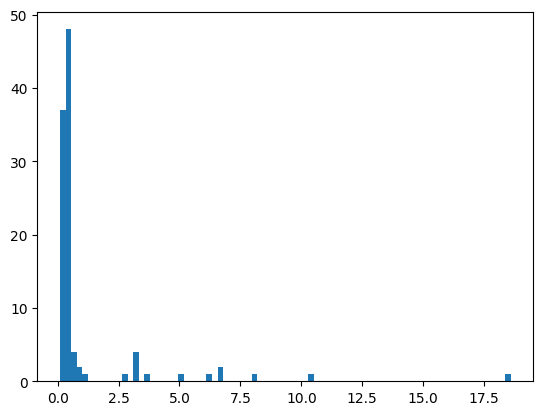

In [26]:
import matplotlib.pyplot as plt
plt.hist(ratios, bins=80)
plt.show()